# Calling the deployed AutoML for Images CV model for vehicles licence plate identification

<p align="center"/>
  <img src="https://miro.medium.com/max/1200/1*PUB8y2T2Qu__nQ3FQj3fmA.jpeg">
</p>


In [1]:
import azureml.core
from azureml.core import Workspace, Dataset
from azureml.core.webservice import Webservice
import requests
import json
import matplotlib.pyplot as plt 
import cv2
import urllib
import time
from azure.cognitiveservices.speech import AudioDataStream, SpeechConfig, SpeechSynthesizer, SpeechSynthesisOutputFormat
from azure.cognitiveservices.speech.audio import AudioOutputConfig
import azure.cognitiveservices.speech as speechsdk
import librosa, librosa.display, IPython.display as ipd

In [2]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [3]:
ws = Workspace.from_config()
print("Azure ML workspace:", ws.name, "\nAzure ML resource group:", ws.resource_group)

Azure ML workspace: azuremlvision 
Azure ML resource group: azuremlvision-rg


## CV models to use

In [4]:
service = Webservice(workspace=ws, name='automl-vehiclelicenceplate')
print(service.scoring_uri)
print(service.swagger_uri)

http://51.105.207.207:80/api/v1/service/automl-vehiclelicenceplate/score
http://51.105.207.207:80/api/v1/service/automl-vehiclelicenceplate/swagger.json


In [5]:
primary, secondary = service.get_keys()

In [6]:
# URL for the web service
scoring_uri = service.scoring_uri
# If the service is authenticated, set the key or token
key = primary

## Image to analyze

In [7]:
# Download images files
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/vehicle4.jpg?raw=true'
imagefile = 'tests/test.jpg'
urllib.request.urlretrieve(image_url, filename=imagefile)

('tests/test.jpg', <http.client.HTTPMessage at 0x7fd64bb04748>)

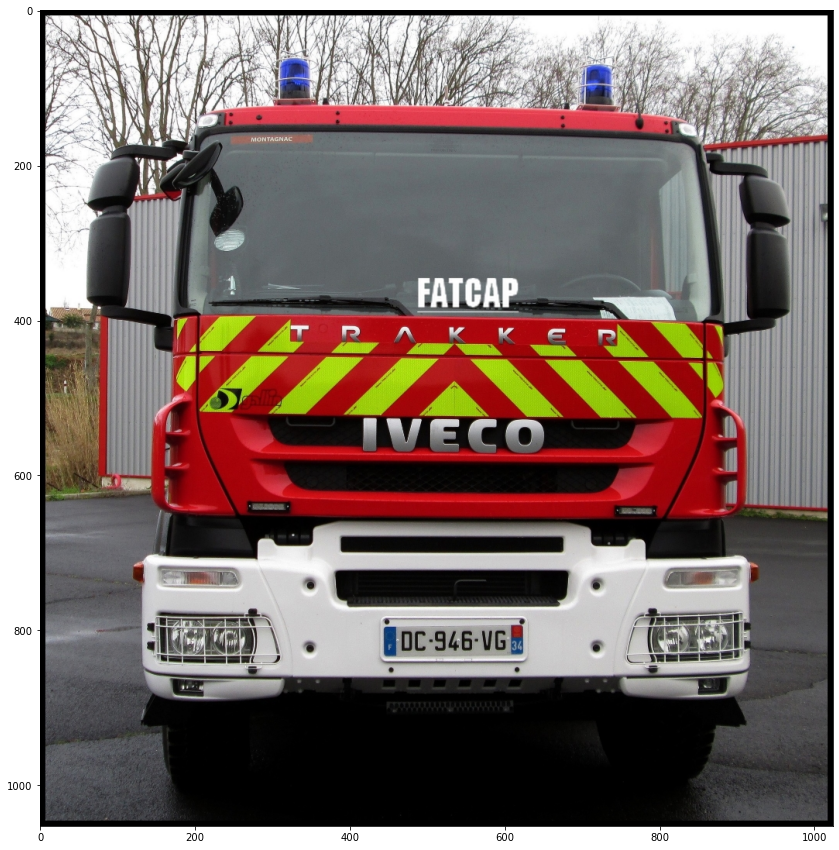

In [8]:
img = cv2.imread(imagefile)
h, w, c = img.shape
plt.figure(figsize=(15,15)) 
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [9]:
%%time
input_data = open(imagefile, 'rb').read()

# Set the content type
headers = {'Content-Type': 'application/json'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, input_data, headers=headers)
print(resp.text)

{"filename": "/tmp/tmpucbj5s2i", "boxes": [{"box": {"topX": 0.42281314567737643, "topY": 0.7471538066864014, "bottomX": 0.6166512835830738, "bottomY": 0.8021341323852539}, "label": "licenceplate", "score": 0.793374240398407}]}

CPU times: user 1.34 ms, sys: 6.63 ms, total: 7.98 ms
Wall time: 375 ms


In [10]:
predictions = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in predictions['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    
predictions

{'filename': '/tmp/tmpucbj5s2i',
 'boxes': [{'box': {'topX': 0.42281314567737643,
    'topY': 0.7471538066864014,
    'bottomX': 0.6166512835830738,
    'bottomY': 0.8021341323852539},
   'label': 'licenceplate',
   'score': 0.793374240398407}]}

In [11]:
tag=predictions['boxes'][0]['label']
prob=predictions['boxes'][0]['score']
roi=predictions['boxes'][0]["box"]
topX=predictions['boxes'][0]["box"]['topX']
topY=predictions['boxes'][0]["box"]['topY']
bottomX=predictions['boxes'][0]["box"]['bottomX']
bottomY=predictions['boxes'][0]["box"]['bottomY']
lpheight=abs(topY-bottomY)

In [12]:
print("Image file:", imagefile)
print('Prediction:', tag, 'with prob =', round(prob, 4))
print('Region:', roi)

Image file: tests/test.jpg
Prediction: licenceplate with prob = 0.7934
Region: {'topX': 0.42281314567737643, 'topY': 0.7471538066864014, 'bottomX': 0.6166512835830738, 'bottomY': 0.8021341323852539}


## Licence plate ROI identification

In [13]:
color1 = (0, 255, 0)
thickness1 = 3
color2 = (0, 255, 0)
fontScale2 = 1
thickness2 = 3
font2 = cv2.FONT_HERSHEY_SIMPLEX
text = tag + ' = ' + str(round(prob,4))

cv2.rectangle(image_rgb, (int(topX*w), int(topY*h)), (int(bottomX*w), int(bottomY*h)), color1, thickness1)
cv2.putText(image_rgb, text, (int(topX*w),int(topY*h-(lpheight*h/2))), font2, fontScale2, color2, thickness2, cv2.LINE_AA)
cv2.imwrite("lpresult.jpg", image_rgb)

True

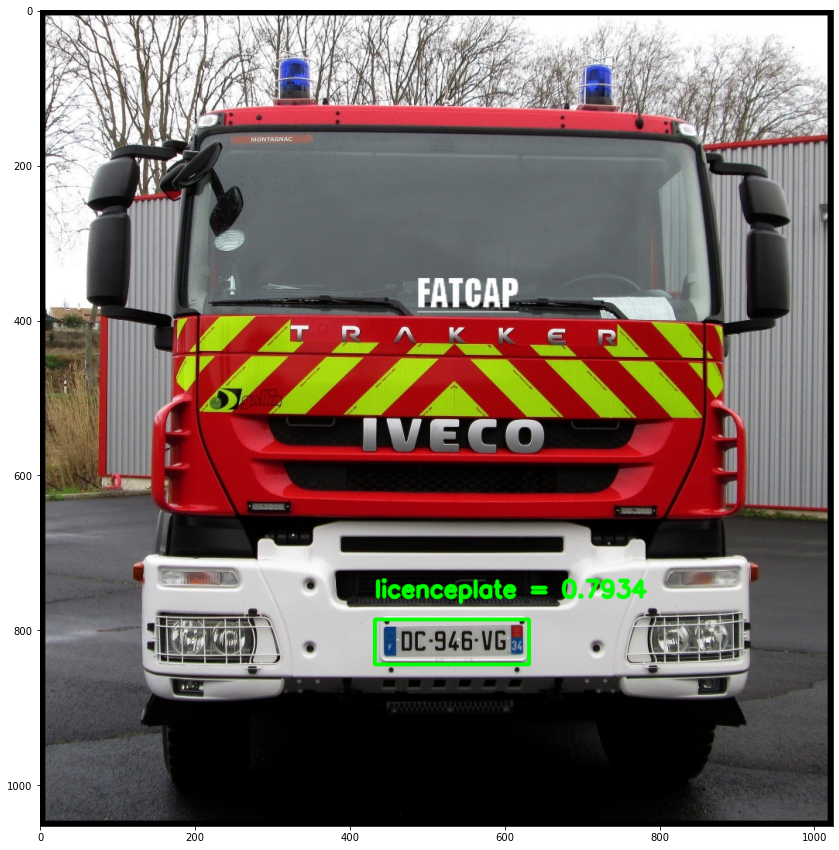

In [14]:
plt.figure(figsize=(15,15)) 
plt.imshow(image_rgb)

## Azure Computer Vision for image captionning

In [15]:
# Your Azure Computer Vision service key and endpoint
subscription_key = 'tobereplaced'
endpoint = 'tobereplaced'

In [16]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
description_results = computervision_client.describe_image(image_url)

# Get the captions (descriptions) from the response, with confidence level
print("Description of the image:\n")
if (len(description_results.captions) == 0):
    print("No description detected.")
else:
    for caption in description_results.captions:
        print("'{}' with confidence = {:.1f}%".format(caption.text, caption.confidence * 100))

Description of the image:

'a red and green fire truck' with confidence = 40.2%


## Extracting the licence plate

In [17]:
x1=int(topX*w)
y1=int(topY*h)
x2=int(bottomX*w)
y2=int(bottomY*h)
plt.figure(figsize=(15,15)) 
licenceplate= image_rgb[y1:y2, x1:x2] # Cropping image to have only the licence plate

<Figure size 1080x1080 with 0 Axes>

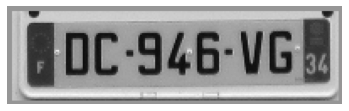

In [18]:
gray = cv2.cvtColor(licenceplate, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray', vmin = 0, vmax = 255)
plt.axis('off')
plt.savefig('results/imagegray.jpg')
plt.show()

## OCR

In [19]:
subscription_key = 'tobereplaced'
endpoint = 'tobereplaced'

In [20]:
azure_text_recognition_url = endpoint + "/vision/v3.2/read/analyze"

image_path = "results/imagegray.jpg"

image_data = open(image_path, "rb").read()
headers = {'Ocp-Apim-Subscription-Key': subscription_key,
           'Content-Type': 'application/octet-stream'}
params = {}
response = requests.post(
    azure_text_recognition_url, headers=headers, params=params, data=image_data)
response.raise_for_status()

operation_url = response.headers["Operation-Location"]

analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers=headers)
    analysis = response_final.json()
    print(json.dumps(analysis, indent=4))
    time.sleep(1)
    if ("analyzeResult" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'failed'):
        poll = False

FullOCR = []
if ("analyzeResult" in analysis):
    # Extract the recognized text, with bounding boxes.
    FullOCR = [(line["boundingBox"], line["text"])
                for line in analysis["analyzeResult"]["readResults"][0]["lines"]]

{
    "status": "running",
    "createdDateTime": "2021-11-03T10:43:14Z",
    "lastUpdatedDateTime": "2021-11-03T10:43:14Z"
}
{
    "status": "succeeded",
    "createdDateTime": "2021-11-03T10:43:14Z",
    "lastUpdatedDateTime": "2021-11-03T10:43:15Z",
    "analyzeResult": {
        "version": "3.2.0",
        "modelVersion": "2021-04-12",
        "readResults": [
            {
                "page": 1,
                "angle": 0,
                "width": 432,
                "height": 288,
                "unit": "pixel",
                "lines": [
                    {
                        "boundingBox": [
                            111,
                            119,
                            340,
                            116,
                            341,
                            162,
                            111,
                            165
                        ],
                        "text": "DC -946-VG",
                        "appearance": {
    

In [26]:
if ("analyzeResult" in analysis):
    LP_OCR = [(line["words"])
                for line in analysis["analyzeResult"]["readResults"][0]["lines"]]
LP_OCR

[[{'boundingBox': [111, 120, 157, 119, 157, 165, 111, 165],
   'text': 'DC',
   'confidence': 0.949},
  {'boundingBox': [166, 119, 334, 117, 334, 163, 166, 165],
   'text': '-946-VG',
   'confidence': 0.42}],
 [{'boundingBox': [82, 148, 89, 148, 89, 160, 82, 160],
   'text': 'F',
   'confidence': 0.996}],
 [{'boundingBox': [352, 138, 377, 138, 377, 164, 352, 164],
   'text': '34',
   'confidence': 0.997}]]

## Licence Plate number

In [27]:
part1 = str(FullOCR[1][1-2])
part2 = str(FullOCR[0][1-2])
part3 = str(FullOCR[2][1-2])
part1 = part1.replace(" ", "") 
part2 = part2.replace(" ", "") 
part3 = part3.replace(" ", "")         
LP = part1 + ' ' + part2 + ' ' + part3
print("\033[1;31;34mVehicle licence plate is:\033[1;31;91m", LP)

Vehicle licence plate is: F DC-946-VG 34


## Reading the Licence Plate with Azure Text to Speech

In [28]:
azureSTT_key = 'tobereplaced'
azureSTT_region = 'tobereplaced'

In [29]:
LanguageToUse = 'EN'

if LanguageToUse == 'FR':
    MSG = "Le numéro d'immatriculation du véhicule est le suivant :" + LP
    LANGUAGE = "fr-FR"
    
if LanguageToUse == 'ES':
    MSG = "El número de registro del vehículo es :" + LP
    LANGUAGE = "es-ES"
    
if LanguageToUse == 'IT':
    MSG = "Il numero di registrazione del veicolo è :" + LP    
    LANGUAGE = "it-IT"

if LanguageToUse == 'EN':
    MSG = "The vehicule licence plate number is " + LP
    LANGUAGE = "en-EN"

if LanguageToUse == 'DE':
    MSG = "Das amtliche Kennzeichen des Fahrzeugs lautet " + LP
    LANGUAGE = "de-DE"
    
audiofile = 'results/licenceplate_' + LanguageToUse + '.wav'

In [30]:
speech_config = SpeechConfig(subscription=azureSTT_key, region=azureSTT_region)
speech_config.speech_synthesis_language = LANGUAGE # Language to use

audio_config = AudioOutputConfig(filename=audiofile)
speech_synthesizer = speechsdk.SpeechSynthesizer(speech_config=speech_config)
synthesizer = SpeechSynthesizer(speech_config=speech_config, audio_config=audio_config,)

synthesizer.speak_text_async(MSG) # Text to Speech using the MSG text

print("///// Azure Text to Speech results /////\n")
from os.path import getsize
sizefile=getsize(audiofile)
print('File is:', audiofile)
print("Audio file date: %s" % time.ctime(os.path.getmtime(audiofile)))
print("Size =", sizefile)

samples, sampling_rate = librosa.load(audiofile, sr = None, mono = True, offset = 0.0, duration = None)
duration = len(samples) / sampling_rate
print("Audio file duration =", round(duration, 3), 'seconds')

///// Azure Text to Speech results /////

File is: results/licenceplate_EN.wav
Audio file date: Wed Nov  3 10:43:51 2021
Size = 172848
Audio file duration = 5.4 seconds


In [31]:
print('Reading the licence plate audio file in', LANGUAGE, ':')
from IPython.display import Audio
Audio(audiofile)

Reading the licence plate audio file in en-EN :


In [32]:
print("\033[1;31;34mVehicle licence plate is:\033[1;31;91m", LP)

Vehicle licence plate is: F DC-946-VG 34


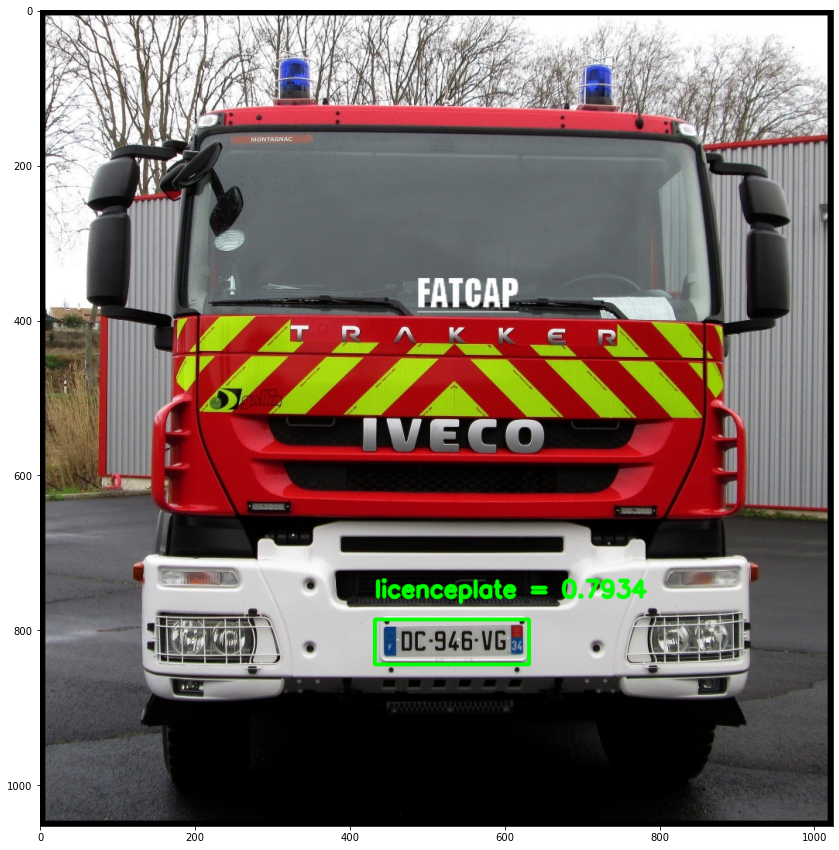

In [33]:
plt.figure(figsize=(15,15)) 
plt.imshow(image_rgb)

> End